In [283]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from scipy import stats
import xgboost as xgb # XGBoost 라이브러리
from sklearn.model_selection import train_test_split # 데이터 분할
from sklearn.metrics import mean_squared_error, r2_score # 회귀 모델 평가 지표
from sklearn.preprocessing import StandardScaler # 스케일링 (선택적)
from sklearn.pipeline import Pipeline # 전처리 및 모델링 파이프라인
from sklearn.impute import SimpleImputer # 결측치 처리를 위한 Imputer (XGBoost 자체 기능 대신 사용 예시)

plt.rcParams['font.family'] = 'Malgun Gothic'

In [284]:
gdf = gpd.read_file("C:/Users/User/Desktop/파이썬/연습문제/venv/practical_project/csv/point_1.shp")

In [285]:
df = pd.read_csv("C:/Users/User/Desktop/파이썬/연습문제/venv/실전프로젝트/farm.csv", encoding="cp949")

In [286]:
df.drop("체세포", axis=1, inplace=True)
df.drop("수집건수", axis=1, inplace=True)
df.drop("축종코드", axis=1, inplace=True)
df.drop("제조사 아이디", axis=1, inplace=True)

In [287]:
df.head() 

,농장아이디,개체번호,측정일시,착유량,착유시작일시,착유종료일시,착유회차,전도도,혈액흐름,온도,유지방,유단백,공기흐름,수집일자
0,20278,20130816010079,2021-09-01 6:52,16,2021-09-01 6:52,2021-09-01 7:04,1,7.1,N,39.9,4.1,3.3,1.5,20210902
1,20278,20130816010079,2021-09-01 17:02,17,2021-09-01 17:02,2021-09-01 17:11,2,6.8,N,40.2,4.5,3.2,2.1,20210902
2,20278,20130816010079,2021-09-02 1:41,14,2021-09-02 1:41,2021-09-02 1:51,1,6.8,N,39.9,4.8,3.1,1.9,20210903
3,20278,20130816010079,2021-09-02 7:28,10,2021-09-02 7:28,2021-09-02 7:36,2,6.8,N,39.6,5.0,3.1,1.7,20210903
4,20278,20130816010079,2021-09-02 14:33,11,2021-09-02 14:33,2021-09-02 14:45,3,6.8,N,40.0,4.7,3.2,1.3,20210903


In [288]:
# 혈액흐름 전처리
df["혈액흐름"] = df["혈액흐름"].apply(lambda x : 0 if x == "N" else 1)

In [289]:
df["측정일시"] = pd.to_datetime(df["측정일시"], format="%Y-%m-%d %H:%M")
df["착유시작일시"] = pd.to_datetime(df["착유시작일시"], format="%Y-%m-%d %H:%M")
df["착유종료일시"] = pd.to_datetime(df["착유종료일시"], format="%Y-%m-%d %H:%M")

In [290]:
df["착유시간"] = df["착유종료일시"] - df["착유시작일시"]

In [291]:
df["착유시간"]  = df["착유시간"].dt.total_seconds() / 60  # 분 단위로 변환

In [292]:
df.head()

,농장아이디,개체번호,측정일시,착유량,착유시작일시,착유종료일시,착유회차,전도도,혈액흐름,온도,유지방,유단백,공기흐름,수집일자,착유시간
0,20278,20130816010079,2021-09-01 06:52:00,16,2021-09-01 06:52:00,2021-09-01 07:04:00,1,7.1,0,39.9,4.1,3.3,1.5,20210902,12.0
1,20278,20130816010079,2021-09-01 17:02:00,17,2021-09-01 17:02:00,2021-09-01 17:11:00,2,6.8,0,40.2,4.5,3.2,2.1,20210902,9.0
2,20278,20130816010079,2021-09-02 01:41:00,14,2021-09-02 01:41:00,2021-09-02 01:51:00,1,6.8,0,39.9,4.8,3.1,1.9,20210903,10.0
3,20278,20130816010079,2021-09-02 07:28:00,10,2021-09-02 07:28:00,2021-09-02 07:36:00,2,6.8,0,39.6,5.0,3.1,1.7,20210903,8.0
4,20278,20130816010079,2021-09-02 14:33:00,11,2021-09-02 14:33:00,2021-09-02 14:45:00,3,6.8,0,40.0,4.7,3.2,1.3,20210903,12.0


## 결측치

In [293]:
df.isnull().sum()

농장아이디      0
개체번호       0
측정일시       0
착유량        0
착유시작일시     0
착유종료일시     0
착유회차       0
전도도        0
혈액흐름       0
온도         0
유지방       52
유단백       52
공기흐름       0
수집일자       0
착유시간       0
dtype: int64

#### 유지방, 유단백 결측치 데이터 탐색

In [294]:
# df[df.isna().any(axis=1)]

In [295]:
# df_null = df[(df["온도"]<38.8) & (df["유지방"].isnull())]

In [296]:
# plt.hist(df_null["착유량"], bins=20, color='blue', alpha=0.7)
# plt.grid(True)
# plt.show()

# 이상치

In [297]:
df.columns

Index(['농장아이디', '개체번호', '측정일시', '착유량', '착유시작일시', '착유종료일시', '착유회차', '전도도',
       '혈액흐름', '온도', '유지방', '유단백', '공기흐름', '수집일자', '착유시간'],
      dtype='object')

전도도 이상치 개수 : 1775
온도 이상치 개수 : 680
공기흐름 이상치 개수 : 303
유지방 이상치 개수 : 592
유단백 이상치 개수 : 343
착유량 이상치 개수 : 474
착유시간 이상치 개수 : 606


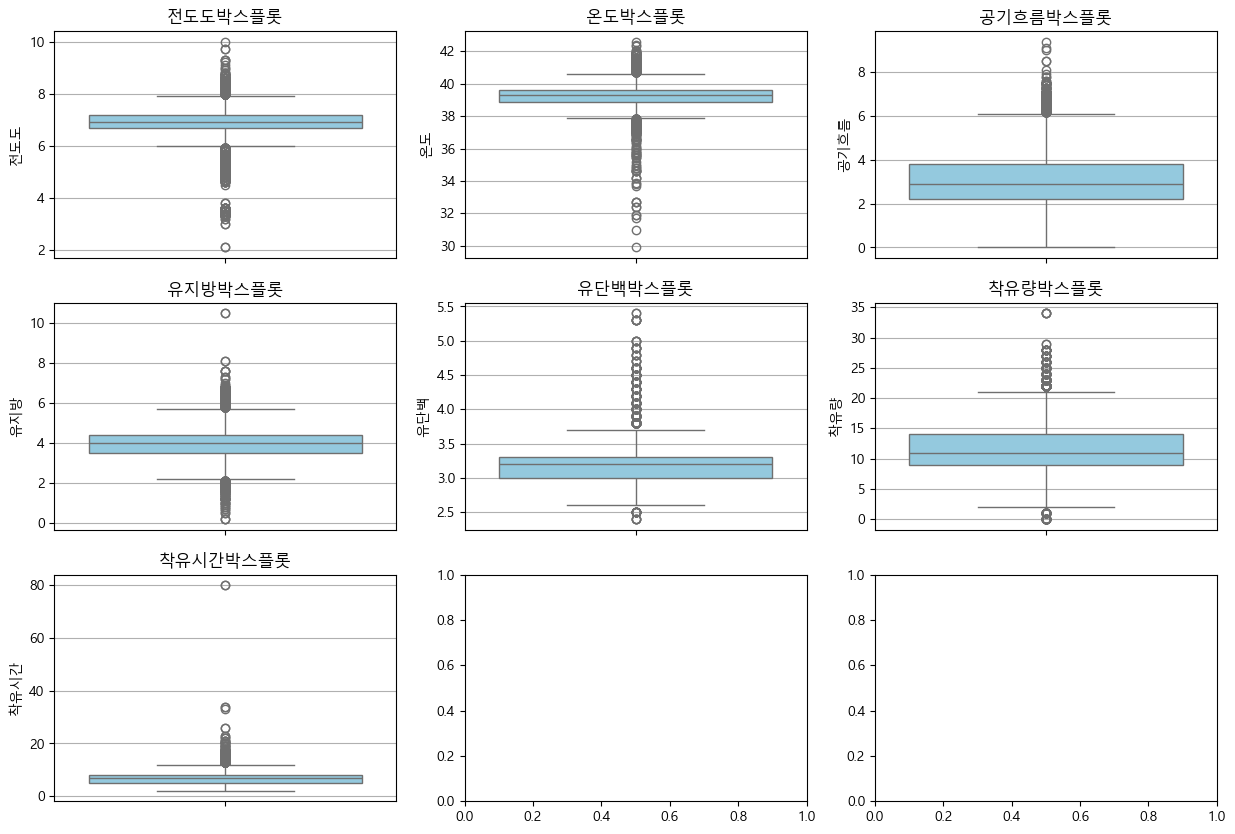

In [298]:
columns = ["전도도","온도","공기흐름","유지방","유단백","착유량","착유시간"]

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15,10))

axes = axes.flatten()

for i, col in enumerate(columns):

    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3-q1
    upper_bound = q3 + 1.5*iqr
    lower_bound = q1 - 1.5*iqr

    ax = axes[i]

    df_outlier = (df[col]<lower_bound) | (df[col]>upper_bound)

    print(f"{col} 이상치 개수 : {df_outlier.sum()}")
    sns.boxplot(y=df[col], ax=ax, color='skyblue')

    ax.set_title(f"{col}박스플롯")
    ax.grid(axis='y',alpha=1)

plt.show()


# 분포 확인 (기존과 log변환 후)

In [299]:
df.columns

Index(['농장아이디', '개체번호', '측정일시', '착유량', '착유시작일시', '착유종료일시', '착유회차', '전도도',
       '혈액흐름', '온도', '유지방', '유단백', '공기흐름', '수집일자', '착유시간'],
      dtype='object')

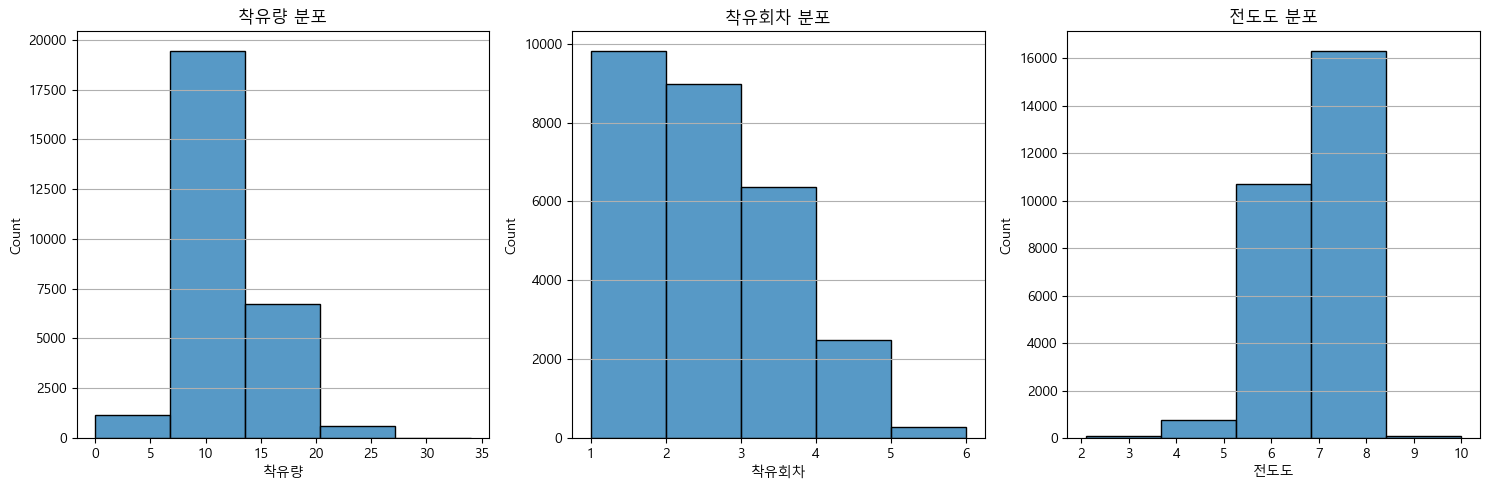

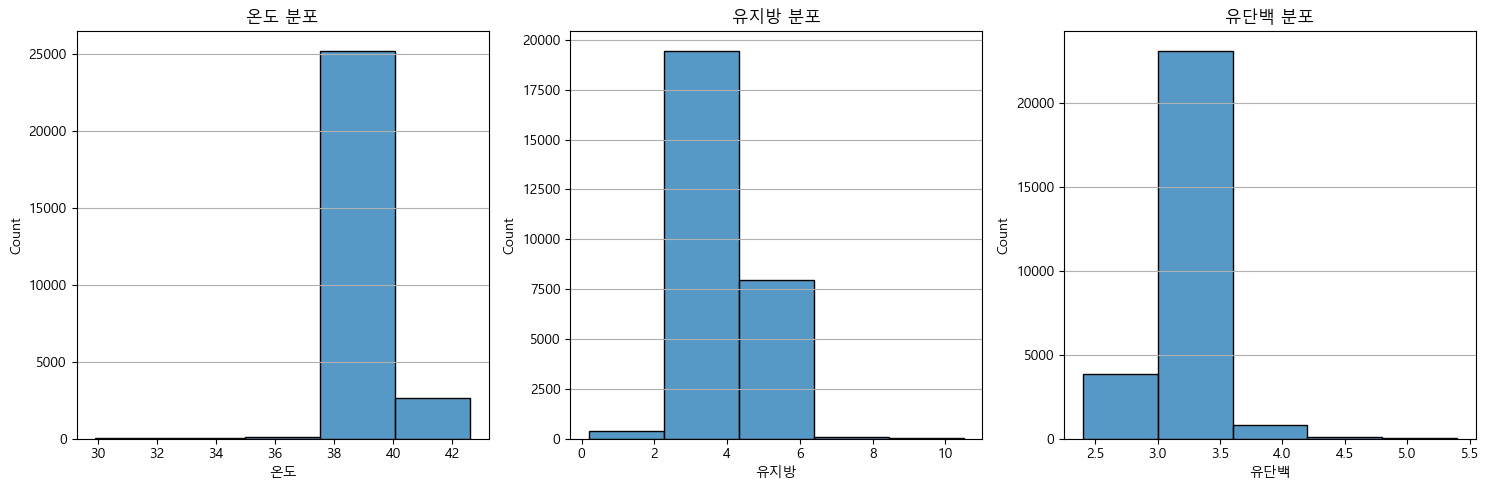

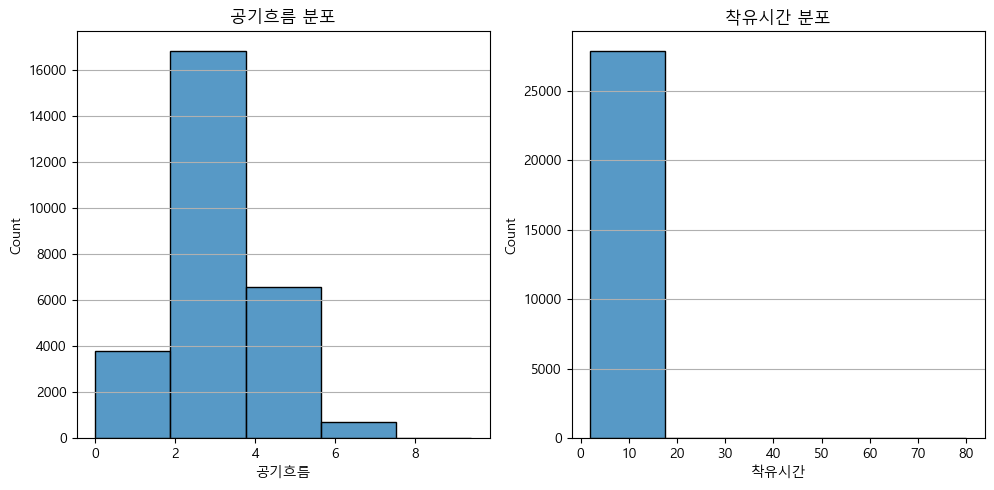

In [300]:
cols = ["착유량","착유회차","전도도","온도","유지방","유단백","공기흐름","착유시간"]

cols_group = [["착유량","착유회차","전도도"],["온도","유지방","유단백"],["공기흐름","착유시간"]]

for x, y in enumerate(cols_group):
    plt.figure(figsize=(15,5))
    
    for i, col in enumerate(y):
        plt.subplot(1,3,i+1)
        sns.histplot(data=df, x=col, bins=5)
        plt.title(f"{col} 분포")
        plt.grid(axis='y', alpha=1)
    plt.tight_layout()
    plt.show()

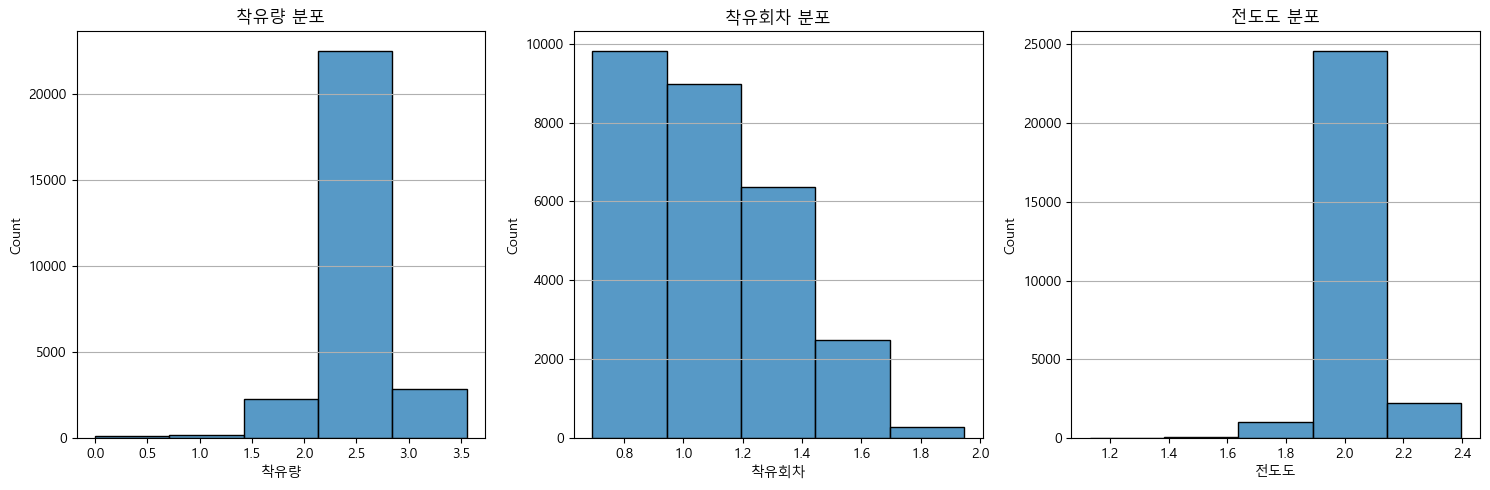

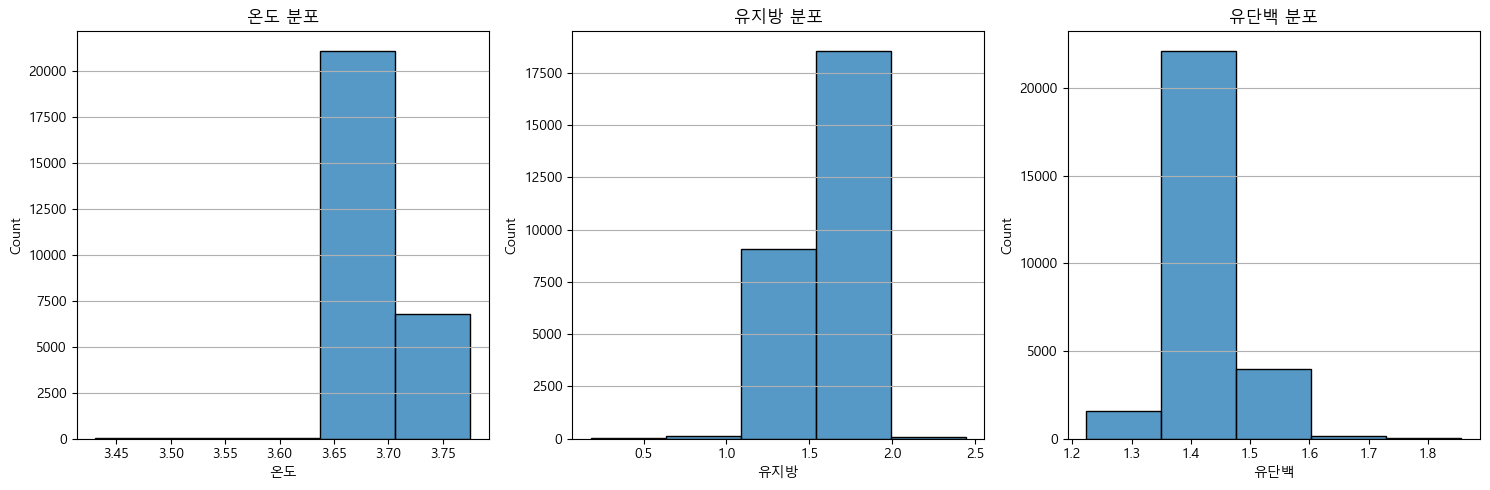

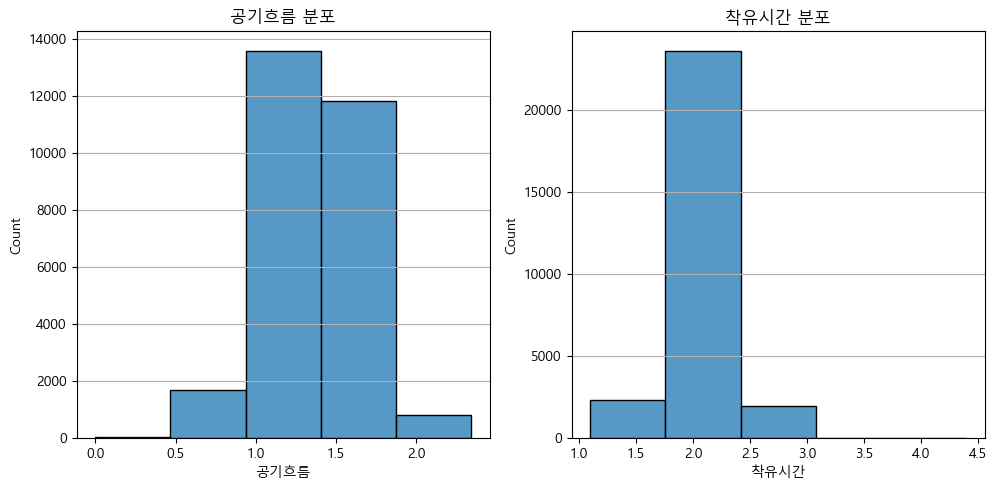

In [301]:
cols = ["착유량","착유회차","전도도","온도","유지방","유단백","공기흐름","착유시간"]

cols_group = [["착유량","착유회차","전도도"],["온도","유지방","유단백"],["공기흐름","착유시간"]]

for x, y in enumerate(cols_group):
    plt.figure(figsize=(15,5))
    
    for i, col in enumerate(y):
        plt.subplot(1,3,i+1)

        log_transformed_col = np.log(df[col]+1)
        df[f"{col}_log"] = log_transformed_col
        sns.histplot(data=log_transformed_col, bins=5)
        plt.title(f"{col} 분포")
        plt.grid(axis='y', alpha=1)
    plt.tight_layout()
    plt.show()

In [302]:
df.head()

,농장아이디,개체번호,측정일시,착유량,착유시작일시,착유종료일시,착유회차,전도도,혈액흐름,온도,...,수집일자,착유시간,착유량_log,착유회차_log,전도도_log,온도_log,유지방_log,유단백_log,공기흐름_log,착유시간_log
0,20278,20130816010079,2021-09-01 06:52:00,16,2021-09-01 06:52:00,2021-09-01 07:04:00,1,7.1,0,39.9,...,20210902,12.0,2.833213,0.693147,2.091864,3.711130,1.629241,1.458615,0.916291,2.564949
1,20278,20130816010079,2021-09-01 17:02:00,17,2021-09-01 17:02:00,2021-09-01 17:11:00,2,6.8,0,40.2,...,20210902,9.0,2.890372,1.098612,2.054124,3.718438,1.704748,1.435085,1.131402,2.302585
2,20278,20130816010079,2021-09-02 01:41:00,14,2021-09-02 01:41:00,2021-09-02 01:51:00,1,6.8,0,39.9,...,20210903,10.0,2.708050,0.693147,2.054124,3.711130,1.757858,1.410987,1.064711,2.397895
3,20278,20130816010079,2021-09-02 07:28:00,10,2021-09-02 07:28:00,2021-09-02 07:36:00,2,6.8,0,39.6,...,20210903,8.0,2.397895,1.098612,2.054124,3.703768,1.791759,1.410987,0.993252,2.197225
4,20278,20130816010079,2021-09-02 14:33:00,11,2021-09-02 14:33:00,2021-09-02 14:45:00,3,6.8,0,40.0,...,20210903,12.0,2.484907,1.386294,2.054124,3.713572,1.740466,1.435085,0.832909,2.564949


# 기본적인 전처리 후 xgboost 돌려보기 (기존, log변환 후)

In [303]:
# 특성(X)과 타겟(y) 분리
# '착유량'이 예측하려는 타겟 변수

X = df[["착유회차","전도도","온도","유지방","유단백","공기흐름","착유시간"]]
y = df['착유량']

# 학습 세트와 검증 세트 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"학습 데이터 X_train 형태: {X_train.shape}")
print(f"검증 데이터 X_test 형태: {X_test.shape}")
print("-" * 40)

# --- XGBoost 모델 생성 및 학습 ---
model = xgb.XGBRegressor(
    objective='reg:squarederror', # 회귀 문제를 위한 손실 함수
    n_estimators=100, # 트리 개수
    learning_rate=0.1, # 학습률
    max_depth=6, # 트리의 최대 깊이
    random_state=42, # 재현성을 위한 랜덤 시드
    tree_method='auto', # 트리 생성 방법 (자동 선택)
    eval_metric='rmse' # 평가 지표 (Root Mean Squared Error)
)
print("\n--- XGBoost 모델 학습 시작 ---")
model.fit(X_train, y_train)
print("--- XGBoost 모델 학습 완료 ---")
print("-" * 40)

# 검증 세트에 대한 예측
y_pred = model.predict(X_test)

# 성능 지표 계산
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"\n--- 모델 평가 결과 ---")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R-squared (R2): {r2:.2f}")
print("-" * 40)

학습 데이터 X_train 형태: (22340, 7)
검증 데이터 X_test 형태: (5586, 7)
----------------------------------------

--- XGBoost 모델 학습 시작 ---
--- XGBoost 모델 학습 완료 ---
----------------------------------------

--- 모델 평가 결과 ---
Mean Squared Error (MSE): 3.80
Root Mean Squared Error (RMSE): 1.95
R-squared (R2): 0.73
----------------------------------------


In [304]:
# 특성(X)과 타겟(y) 분리
# '착유량'이 예측하려는 타겟 변수

X = df[["착유회차_log","전도도_log","온도_log","유지방_log","유단백_log","공기흐름_log","착유시간_log"]]
y = df['착유량']

# 학습 세트와 검증 세트 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"학습 데이터 X_train 형태: {X_train.shape}")
print(f"검증 데이터 X_test 형태: {X_test.shape}")
print("-" * 40)

# --- XGBoost 모델 생성 및 학습 ---
model = xgb.XGBRegressor(
    objective='reg:squarederror', # 회귀 문제를 위한 손실 함수
    n_estimators=100, # 트리 개수
    learning_rate=0.1, # 학습률
    max_depth=6, # 트리의 최대 깊이
    random_state=42, # 재현성을 위한 랜덤 시드
    tree_method='auto', # 트리 생성 방법 (자동 선택)
    eval_metric='rmse' # 평가 지표 (Root Mean Squared Error)
)
print("\n--- XGBoost 모델 학습 시작 ---")
model.fit(X_train, y_train)
print("--- XGBoost 모델 학습 완료 ---")
print("-" * 40)

# 검증 세트에 대한 예측
y_pred = model.predict(X_test)

# 성능 지표 계산
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"\n--- 모델 평가 결과 ---")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R-squared (R2): {r2:.2f}")
print("-" * 40)

학습 데이터 X_train 형태: (22340, 7)
검증 데이터 X_test 형태: (5586, 7)
----------------------------------------

--- XGBoost 모델 학습 시작 ---
--- XGBoost 모델 학습 완료 ---
----------------------------------------

--- 모델 평가 결과 ---
Mean Squared Error (MSE): 3.80
Root Mean Squared Error (RMSE): 1.95
R-squared (R2): 0.73
----------------------------------------


In [305]:
df.head()

,농장아이디,개체번호,측정일시,착유량,착유시작일시,착유종료일시,착유회차,전도도,혈액흐름,온도,...,수집일자,착유시간,착유량_log,착유회차_log,전도도_log,온도_log,유지방_log,유단백_log,공기흐름_log,착유시간_log
0,20278,20130816010079,2021-09-01 06:52:00,16,2021-09-01 06:52:00,2021-09-01 07:04:00,1,7.1,0,39.9,...,20210902,12.0,2.833213,0.693147,2.091864,3.711130,1.629241,1.458615,0.916291,2.564949
1,20278,20130816010079,2021-09-01 17:02:00,17,2021-09-01 17:02:00,2021-09-01 17:11:00,2,6.8,0,40.2,...,20210902,9.0,2.890372,1.098612,2.054124,3.718438,1.704748,1.435085,1.131402,2.302585
2,20278,20130816010079,2021-09-02 01:41:00,14,2021-09-02 01:41:00,2021-09-02 01:51:00,1,6.8,0,39.9,...,20210903,10.0,2.708050,0.693147,2.054124,3.711130,1.757858,1.410987,1.064711,2.397895
3,20278,20130816010079,2021-09-02 07:28:00,10,2021-09-02 07:28:00,2021-09-02 07:36:00,2,6.8,0,39.6,...,20210903,8.0,2.397895,1.098612,2.054124,3.703768,1.791759,1.410987,0.993252,2.197225
4,20278,20130816010079,2021-09-02 14:33:00,11,2021-09-02 14:33:00,2021-09-02 14:45:00,3,6.8,0,40.0,...,20210903,12.0,2.484907,1.386294,2.054124,3.713572,1.740466,1.435085,0.832909,2.564949


In [306]:
df.to_csv("test.csv", index=False)